# Physics-Based Neural Networks for Planetary Science: A Tutorial

# Introduction
This tutorial demonstrates how to apply **Physics-Informed Neural Networks (PINNs)** to a planetary science problem. Specifically, we will solve a heat conduction problem in a planetary crust. PINNs combine physical laws (expressed as partial differential equations, PDEs) with data-driven machine learning.

# Objectives
1. Model heat conduction in a planetary crust using PINNs.
2. Understand how physical constraints are embedded in a neural network.
3. Apply the trained PINN to predict temperature profiles in a realistic planetary setting.

In [1]:
# Import Libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.special import erf

# Define the Heat Conduction Problem
Heat conduction in a 1D planetary crust is governed by:  
$$ \frac{\partial T}{\partial t} = \alpha \frac{\partial^2 T}{\partial x^2} $$

where:
- $T$ is temperature (K),
- $\alpha$ is thermal diffusivity $(m^2/s)$,
- $x$ is depth (m),
- $t$ is time (s).

In [2]:
# Define Physical Constants

# Thermal diffusivity (m^2/s)
alpha = 1e-6

# Spatial domain (depth, in meters)
x_min, x_max = 0, 1000

# Time domain (in seconds)
t_min, t_max = 0, 1e6

# Generate Training Data
We will generate synthetic temperature data for training using an analytical solution to the heat equation:
$$ T(x, t) = T_0 + (T_s - T_0) \text{erf}\left( \frac{x}{2\sqrt{\alpha t}} \right) $$

Text(0.5, 1.0, 'Training Data')

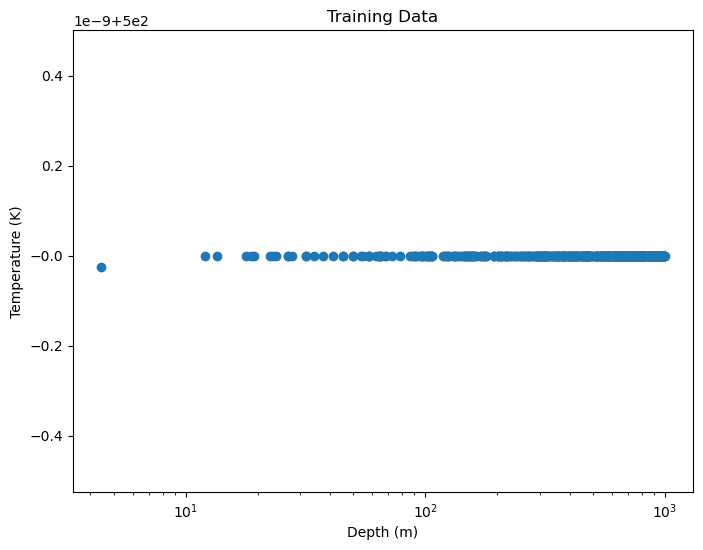

In [18]:
def generate_training_data(n_points=500):
    """Generate synthetic data for training."""
    x = np.random.uniform(x_min, x_max, n_points)
    t = np.random.uniform(t_min, t_max, n_points)
    
    T_0 = 500  # Initial temperature (K)
    T_s = 300   # Surface temperature (K)
    
    T = T_s + (T_0 - T_s) * erf(x / (2 * np.sqrt(alpha * t)))
    
    return x, t, T

x_train, t_train, T_train = generate_training_data()

# Plot the training data
plt.figure(figsize=(8, 6))
plt.scatter(x_train, T_train)
# plt.yscale('log')
plt.xscale('log')
plt.xlabel('Depth (m)')
plt.ylabel('Temperature (K)')
plt.title('Training Data')


# PINN Model
Define a neural network that predicts temperature $T(x, t)$ and embeds the heat conduction equation as a constraint.

In [20]:
def build_model():
    """Build the neural network model."""
    inputs = tf.keras.Input(shape=(2,))  # Inputs: (x, t)
    x = tf.keras.layers.Dense(64, activation='swish')(inputs)
    x = tf.keras.layers.Dense(64, activation='swish')(x)
    outputs = tf.keras.layers.Dense(1)(x)  # Output: T
    return tf.keras.Model(inputs, outputs)

model = build_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,417 (17.25 KB)

 Trainable params: 4,417 (17.25 KB)

 Non-trainable params: 0 (0.00 B)

# Physics-Informed Loss Function
The loss function has two components:
1. **Data Loss**: Measures the error between predicted and observed temperature.
2. **Physics Loss**: Ensures the network satisfies the heat equation.

In [21]:
def physics_loss(x, t):
    """Compute the physics loss based on the heat equation."""
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([x, t])
        T = model(tf.concat([x, t], axis=1))  # Predicted temperature

        # Gradients
        T_x = tape.gradient(T, x)
        T_t = tape.gradient(T, t)
        T_xx = tape.gradient(T_x, x)

    del tape
    
    # Heat equation residual
    residual = T_t - alpha * T_xx
    return tf.reduce_mean(tf.square(residual))

def combined_loss(x, t, T_true):
    """Combine data and physics losses."""
    T_pred = model(tf.concat([x, t], axis=1))
    data_loss = tf.reduce_mean(tf.square(T_true - T_pred))
    phys_loss = physics_loss(x, t)
    return data_loss + phys_loss

# Training the PINN

In [ ]:
# Training the PINN
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

@tf.function
def train_step(x, t, T_true):
    with tf.GradientTape() as tape:
        loss = combined_loss(x, t, T_true)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

# Train the model
n_epochs = 5001
for epoch in range(n_epochs):
    x_batch = tf.convert_to_tensor(x_train.reshape(-1, 1), dtype=tf.float32)
    t_batch = tf.convert_to_tensor(t_train.reshape(-1, 1), dtype=tf.float32)
    T_batch = tf.convert_to_tensor(T_train.reshape(-1, 1), dtype=tf.float32)

    loss = train_step(x_batch, t_batch, T_batch)

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.numpy()}")

Epoch 0, Loss: 125270864.0
Epoch 500, Loss: 27983.1796875
Epoch 1000, Loss: 37304.828125
Epoch 1500, Loss: 220046.265625
Epoch 2000, Loss: 315585.21875
Epoch 2500, Loss: 43258.375
Epoch 3000, Loss: 322354.84375
Epoch 3500, Loss: 217601.96875
Epoch 4000, Loss: 106023.6796875
Epoch 4500, Loss: 218815.296875


# Evaluate the Model

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


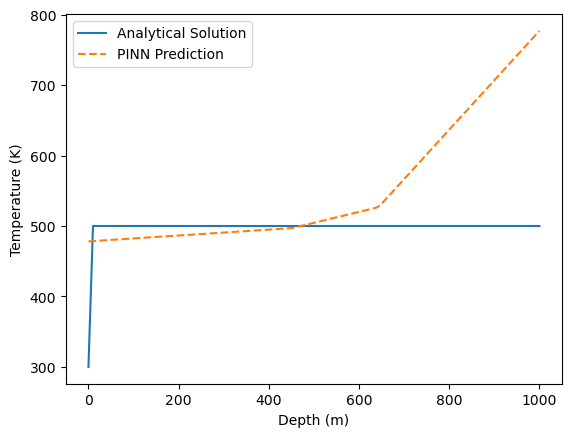

In [25]:
# Predict temperature profiles and compare with the analytical solution.
# Test data
x_test = np.linspace(x_min, x_max, 100)
t_test = np.full_like(x_test, t_max / 2)

# Predict
x_tensor = tf.convert_to_tensor(x_test.reshape(-1, 1), dtype=tf.float32)
t_tensor = tf.convert_to_tensor(t_test.reshape(-1, 1), dtype=tf.float32)
T_pred = model.predict(tf.concat([x_tensor, t_tensor], axis=1))

# Analytical solution
T_true = 300 + (500 - 300) * erf(x_test / (2 * np.sqrt(alpha * (t_max / 2))))

# Plot results
plt.plot(x_test, T_true, label='Analytical Solution')
plt.plot(x_test, T_pred, '--', label='PINN Prediction')
plt.xlabel('Depth (m)')
plt.ylabel('Temperature (K)')
plt.legend()
plt.show()


# Conclusion
In this tutorial, we demonstrated how to build and train a PINN to solve a heat conduction problem in a planetary crust. By combining physics-based constraints with data-driven learning, PINNs provide a powerful framework for planetary science applications.
